# Job Scheduling Problem

---
### Credits

<div class="alert alert-block alert-info">
I need to acknowledge a couple of sources: 
 <ul>
   <li> Prof. Jeff Erickson's exposition - <a href="https://jeffe.cs.illinois.edu/teaching/algorithms/notes/J-approx.pdf"> click here</a> and 
   <li> Graham, R. L. “Bounds on Multiprocessing Timing Anomalies.” SIAM Journal on Applied Mathematics, vol. 17, no. 2, 1969, pp. 416–29. JSTOR, <a href="http://www.jstor.org/stable/2099572"> click here</a>.
    </ul>
</div>


Imagine you have a list of $n$ tasks to be done (in parallel) by $m$ processors. Note that t$m < n$, of course, or else the problem is trivial: just assign each job to its own processor and we can be done as fast as needed.

  - Tasks are numbered $1, \ldots, n$.
  - Task $j$ requires time $T[j] \geq 0$, where we provide $T[j]$ as an input.

Your goal is to assign each task to one of the processors. Such an assignment is a mapping
$$ A: \{ 1, \ldots, n \} \mapsto \{ 1,\ldots, m \} \,,$$
wherein $A(i)$ maps task $i \in \{1, \ldots, n \}$  to a processor $j \in \{1, \ldots, m\}$.


### Example 

Consider 5 tasks with timings: 
$$ T[1] = 2, T[2] = 1, T[3] = 4, T[4] = 2, T[5] = 1$$
and $2$ processors that can carry them out.

Suppose we have the following assignment: 
$$A(1) = 1, A(2) = 1, A(3) = 2, A(4) = 2, A(5) = 1,$$
wherein we have assigned tasks $1, 2, 5$ to processor $1$ and tasks $3,4$ to processor $2$.

Under this assignment assume all processors begin their assigned tasks at the same time. Each processor carries out its assigned tasks in some order which we do not care to specify here. We are simply concerned with how much time it takes each processor to finish its assigned tasks.

Returning back to the example, processor # 1 will finish its assigned tasks in time $T[1] + T[2] + T[5] = 4$ time units whereas processor # 2 will require time $T[3] + T[4] = 6$ time units.

### Makespan

The makespan of an assignment is the time taken by the longest running processor to finish all of its assigned tasks. In the example above, the makespan is given by 6 time units since processor # 2 which is the longest running takes 6 units of time to finish its assigned tasks.

<div class="alert alert-block alert-info">
 Our goal is to find an assignment $A$ that assigns $n$ given tasks with timings $T[1], \ldots, T[n]$ to $m$ processors in a way that _minimizes_ the  makespan of the assignment $A$.
</div>

Returning back to our example above, consider a different assignment $\hat{A}$ as follows:

$$ \hat{A}(1) = 1, \hat{A}(2) = 1, \hat{A}(3) = 2, \hat{A}(4) = 1, \hat{A}(5) = 2$$

In other words, $\hat{A}$ assigns tasks $1, 2, 4$ to processor # 1 and tasks $3,5$ to processor # 2. What is the makespan of this assignment?

Clearly, processors 1 and 2 both require $5$ time units to finish their tasks. The longest running is either of these and the makespan is also $5$ time units.

$\hat{A}$ is better than $A$ since it has reduced the overall makespan from $6$ for $A$ to $5$ for $\hat{A}$.

__Question to Ponder:__ Is there an assignment of tasks to processors with a strictlty smaller makespan than $\hat{A}$ for this example?


## Makespan Minimizing Schedule

The problem of finding an assignment which minimizes the makespan is NP-complete (note that we would formulate it as a "decision problem" in the first place and the proof reduces from a known NP-complete problem called the integer PARTITION problem and is left as an exercise).

#### ILP Formulation

We can solve it as an integer linear programming problem.

The decision variables are

  - Binary variable $w_{i,j}$ for $i \in \{1, \ldots, n\}$ and $j \in \{1, \ldots, m\}$ where $w_{i, j} = 1$ if we assign task $i$ to processor $j$ and $0$ otherwise.
  - We add a variable $M$ representing the makespan.
  
  
The objective is to minimize $M$.

Constraints are as follows: 
  - Each job is to be assigned to precisely one processor: $\sum_{j=1}^m w_{i,j} = 1$ for each $i \in \{1, \ldots, n\}$.
  - The total working time for each processor must be less than or equal to the overall makespan: $\sum_{i=1}^n T[i] w_{i,j} \leq M$ for each $j \in \{1, \ldots, m \}$.
  

The overall ILP is therefore, 

$\begin{array}{rll}
\min & M &\ \leftarrow \text{minimize makespan}\\ 
\mathsf{s.t.} & \sum_{j=1}^m w_{i,j} = 1 & \ \text{for all}\ i= 1, \ldots, n \\ 
& \sum_{i=1}^n T[i] w_{i,j} \leq M & \ \text{for all}\ j = 1, \ldots, m \\ 
& w_{i,j} \in \{0, 1\} &\ \text{for all}\ i = 1, \ldots, n,\ \text{for all}\ j = 1, \ldots, m\\ 
\end{array}$

It is a problem with $mn$ binary (0-1) decision variables and $m +n$ constraints.

In [1]:
from pulp import *

def formulate_min_makespan(task_times, m):
    n = len(task_times)
    assert m < n
    prob = LpProblem('min-makespan', LpMinimize)
    # create a list of list of indicator variables w_i_j
    indicator_vars = [ [LpVariable(f'w_{i}_{j}', cat='Binary') for j in range(m)] for i in range(n) ]
    M = LpVariable('M', cat='Continuous') # create a variable M for makespan -- it is real-valued
    # set objective
    prob += M
    # add constraints
    # each task must be assigned to exactly one processor
    for i in range(n): # for each task
        prob += lpSum(indicator_vars[i]) == 1
    # working time for each processor must be less than the makespan
    for j in range(m):
        vars_i = [indicator_vars[i][j] for i in range(n)]
        prob += lpDot(task_times, vars_i) <= M # lpDot is a very useful function that pulp supports to take dot product of two lists
    # solve and extract answer
    prob.solve()
    assert prob.status == constants.LpStatusOptimal
    # extract the job assignment
    A = []
    for i in range(n):
        w_list = indicator_vars[i]
        ## TODO: Replace code below using a suitable python list API function
        assigned_proc = None
        for j in range(m):
            if w_list[j].varValue > 0:
                assigned_proc = j
                break
        assert assigned_proc != None, f'Task # {i} did not get assigned to any processor. There is a bug in problem formulation'
        A.append(assigned_proc)
    return (A, M.varValue)
    

In [2]:
(A, mkSpan) = formulate_min_makespan([2,1,4,2,1], 2)
print('Assignment')
print('----------------------')
for i in range(5):
    print(f'Task # {i+1} assigned to processor # {A[i]+1}')
print(f'MakeSpan is {mkSpan}')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /usr/local/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/50/3l1vyzp13ss44tvgw3b1vw3c0000gn/T/13895f7ce3be4ee38520f22ff7b741b4-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/50/3l1vyzp13ss44tvgw3b1vw3c0000gn/T/13895f7ce3be4ee38520f22ff7b741b4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 56 RHS
At line 64 BOUNDS
At line 76 ENDATA
Problem MODEL has 7 rows, 11 columns and 22 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5 - 0.00 seconds
Cgl0004I processed model has 2 rows, 4 columns (3 integer (1 of which binary)) and 8 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 5
Cbc0038I Relaxing continuous gives 5
Cbc0038I Cleaned solut

## Approximation Algorithm 

Unfortunately, ILPs have an exponential running time in terms of the number of jobs and processors. Unless P = NP, we cannot really hope for a polynomial time solution. 

However, we will now formulate an approximation algorithm which will solve the same problem but will have a guaranteed approximation ratio. In particular, we will guarantee that 

$$ M^* \leq M_{\text{appr}} \leq 2 M^*$$

where $M^*$ is the best possible make-span (that computed by the ILP for instance) and $M_{\text{appr}}$ is the makespan for the (suboptimal) assignment provided by our algorithm. 



> Although our approximation algorithm provides a suboptimal solution, it is guaranteed to be within a factor of 2 of the best possible solution.


The approximation algorithm in this case is actually a greedy algorithm. 
  - We go through the tasks in order from $1$ to $n$.
  - When we process task number $i$, we maintain two pieces of information:
    - The partial assignment $A$ for previously considered  tasks from $1$ to $i-1$.
    - The time commitment $K[j]$ for each processor $j = 1, \ldots, m$ which is simply the sum of all timings of tasks associated with it.
    
To begin with $A$ is empty mapping and $K[j] = 0$ for all processors $j = 1, \ldots, m$.

The greedy algorithm is simple: 
  - Assign job $i$ to the processor $j$ which has the lowest time commitment so far. In other words, the processor $j$ for which $K[j]$ is the least value.
  
The greedy algorithm stops when all tasks have been processed.

~~~
1. initialize array K of size m to all 0s.
2. initialize array A of size n to all NILs.
3. for i = 1 to n :        # Iterate through each task in order
    3.1 j = argmin(K)      # choose index of the smallest entry in the array K.
    3.2 A[i] = j           # Assign task i to processor j
    3.3 K[j] = K[j] + T[i] # update the total time of tasks committed to processor j
4. return A
~~~

### Example

Let's go back to the example from before:
$$ T[1] = 2, T[2] = 1, T[3] = 4, T[4] = 2, T[5] = 1$$

The algorithm considers tasks  $1,2, \ldots, 5$ in turn. Here is how its execution goes:
  - Initially: Assignment $A$ is empty and $K[1] = K[2] = 0$.
  - Task # 1 is assigned to either processor since they both have $0$ time commitment.
     - $A[1] = 1, K[1] = 2, K[2] = 0$.
  - Task # 2 is assigned to processor 2 since $K[2]$ is the minimum.
     - $A[2] = 2, K[1] = 2, K[2] = 1 $.
  - Task # 3 is assigned to processor 2 since $K[2]$ is the minimum.
     - $A[3] = 2, K[1] = 2, K[2] = 5$.
  - Task # 4 is assigned to processor 1.
     - $A[4] = 1, K[1] = 4, K[2] = 5 $.
  - Task # 5 is assigned to processor 1.
     - $A[5] = 1, K[1] = 5, K[2] = 5$.
     
 In this example, our greedy algorithm matches the performance of our ILP in terms of makespan.
 
 What is the running time? By keeping a priority queue for the array $K$, we can find and update the minimum time commitment queue $K$ in $O(\log(m))$ time. The overall running time would be $n \log(m)$, which is much faster than the worst case exponential running time of the ILP.

In [38]:
def greedy_jobshop_scheduling(timings, m):
    n = len(timings)
    A = []
    K = [(0,j) for j in range(m)] # for simplicity of coding maintain K as a array of tuples consisting of timing and processor index
    for i in range(n):
        print(f'K = {K}')
        (min_proc_timing, min_proc_idx) = min(K) # this can be improvedd using a priority queue but right now this will take O(m) time
        A.append(min_proc_idx) 
        print(f'Task {i} assigned to processor {min_proc_idx}')
        K[min_proc_idx] = (min_proc_timing + timings[i], min_proc_idx) # update the array K
    print(f'K = {K}')
    makeSpan, max_proc_idx = max(K)
    print(f'Make span = {makeSpan}')
    return A

    

In [22]:
A = greedy_jobshop_scheduling([2,1,4,2,1], 2)

K = [(0, 0), (0, 1)]
Task 0 assigned to processor 0
K = [(2, 0), (0, 1)]
Task 1 assigned to processor 1
K = [(2, 0), (1, 1)]
Task 2 assigned to processor 1
K = [(2, 0), (5, 1)]
Task 3 assigned to processor 0
K = [(4, 0), (5, 1)]
Task 4 assigned to processor 0
K = [(5, 0), (5, 1)]
Make span = 5


## Analysis of Greedy Algorithm

We will now prove that the greedy algorithm yields an assignment whose makespan is no worse than twice the best possible makespan.

Let us suppose we ran the greedy algorithm on a problem with $n$ tasks whose timings are $T[1], \ldots, T[n]$ assigned to $m$ processors. Let $M^*$ be be best possible makespan and $M_g$ be that provided by our greedy algorithm.

The makespan $M_g$ is the assigned total load for some processor at the end of our greedy algorithm. Let this be processor $j$.

Let us fix the following notation: 
  - $K^{(1)}$ is the starting value for the array $K$. I.e, $K^{(0)}[j] = 0$ for all $j \in \{1, \ldots, m \}$.
  - At the start of iteration $i$ of the loop, let the contents of the array $K$ be denoted $K^{(i)}$. 
  - Finally, $K^{(n+1)}$ is the value of $K$ at the end of the algorithm.


The makespan $M_g$ must be determined by some processor $j$, i.e, $K^{(n+1)}[j] = M_g$ and let $i$ be the last task that was added to this processor.

Consider the array of commitments $K^{(i)} $ at the point of time before we added task # i (tthe makespan determining task) to processor $j$. Thus, 
  - $K^{(i)}[j]$ is the total of all task timings that  were previously assigned to processor $j$
  - $K^{(i)}[j] + T[i] = M_g $ is the final makespan of the greedy algorithm.

Let $K$ be the final commitments after the greedy algorithm has finished running. Here is a picture to keep in mind showing $K^{(i)} $ the snapshot when the makespan determining task $i$ is  added to processor $j$.

<div> 
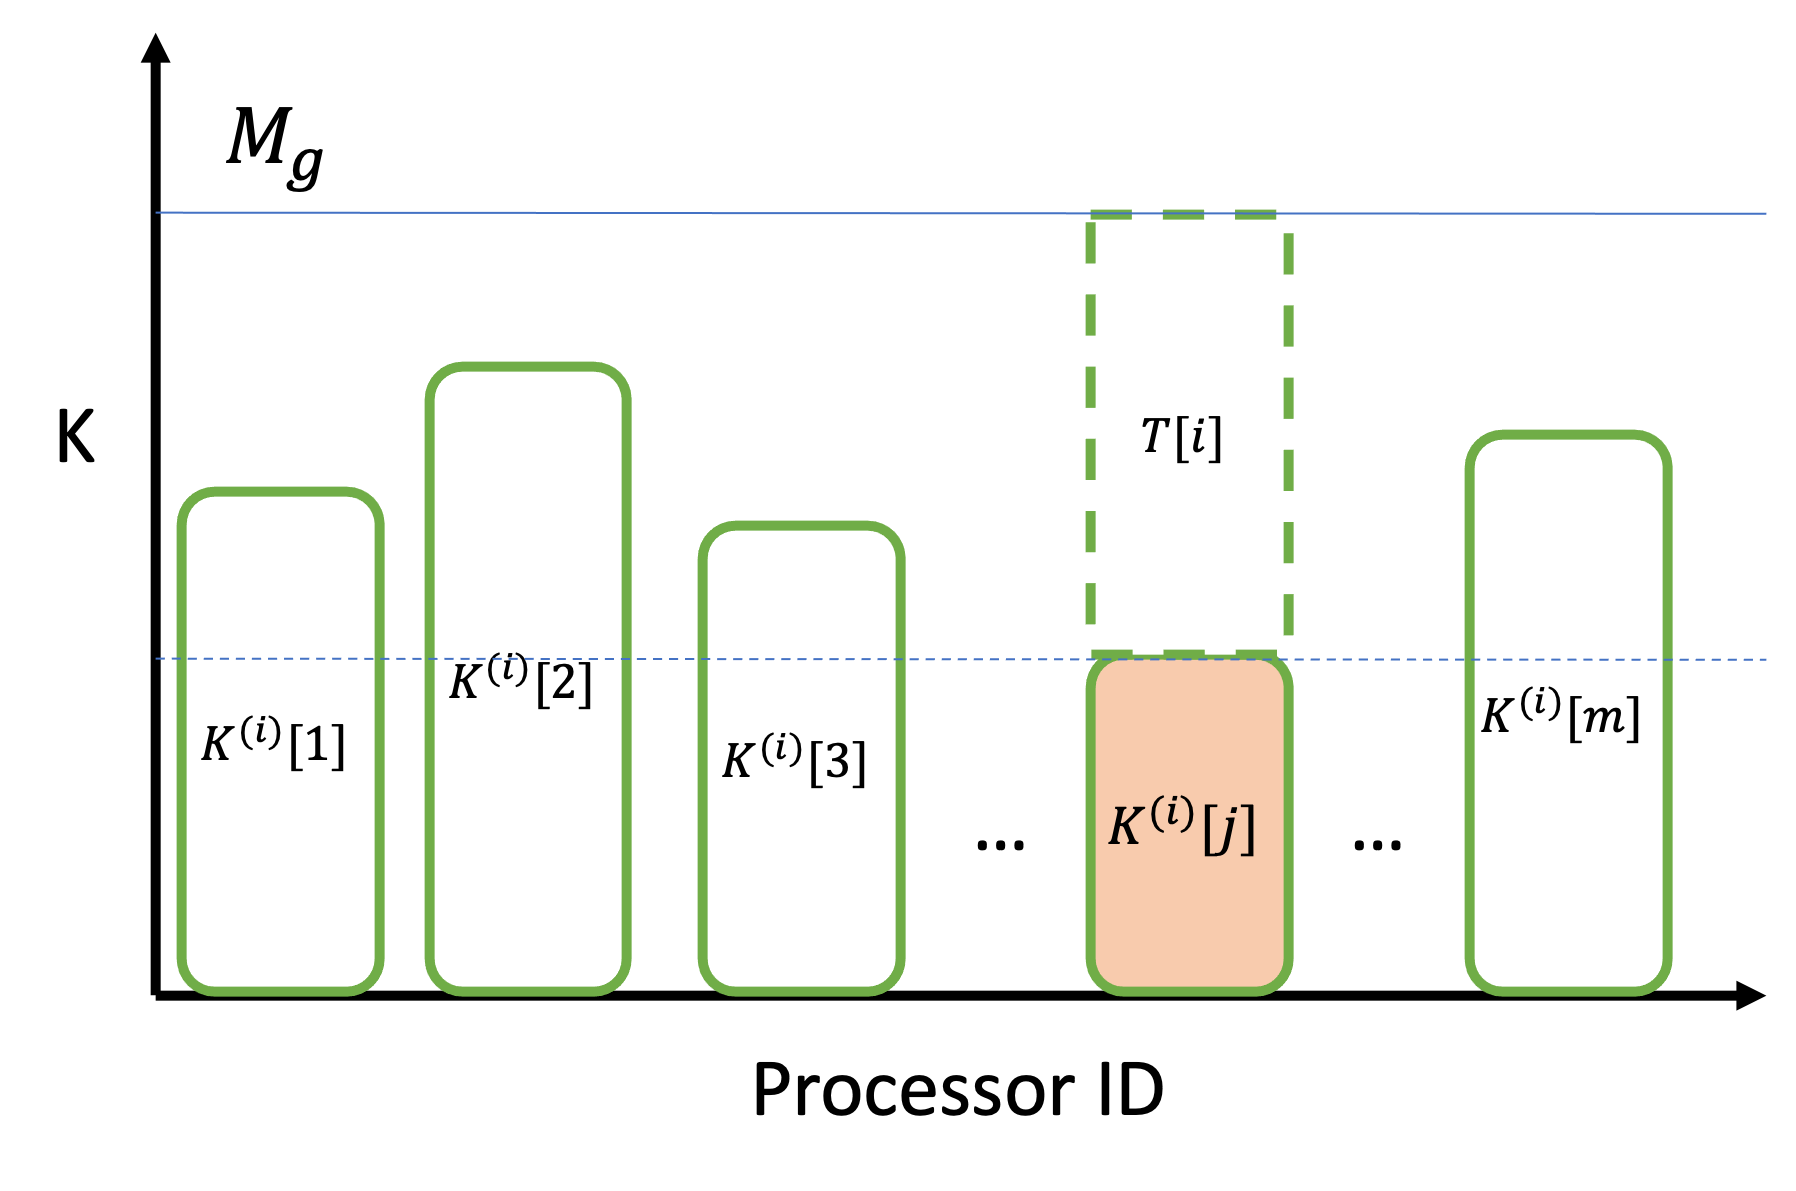
</div>


The greedy algorithm chose to add the job $T[i]$ to processor $j$ because $K^{(i)}[j]$ was the minimal value in the array $K^{(i)}$. I.e, for all processors $l$, we have:
  - $K^{(i)} [j] \leq K^{(i)}[l]$.
   
Therefore, 
 $$ \begin{array}{rll}
 m K^{(i)}[j] &  \leq K^{(i)}[1] + K^{(i)}[2] + \cdots + K^{(i)}[m] & \text{Adding all the values of} K^{(i)} \ \text{and using inequality above.}\\ 
 & \leq T[1] + T[2] + \cdots + T[i-1] & \text{Because, we have added tasks 1, ..., i-1, already}\\ 
 & \leq T[1] +  \cdots + T[n]  \\
 \end{array} $$ 
or in other words,
  $$ K^{(i)}[j] \leq \frac{1}{m} ( T[1] + \ldots, T[n] )\,.$$

We also know that $$M_g = K^{(i)}[j] + T[i] \,.$$
  
Now, what can we say about $M^*$ the best possible makespan??
  1. The makespan of _any_ assignment has to be greater than or equal to the timings of each individual task (each task has to be  assigned to a processor with possibly other tasks to that processor). Therefore, $M^* \geq T[i]$.
  2. Second, as we are assigning tasks with timings $T[1], T[2], \ldots, T[n]$ among $n$ processors, let's consider the _average_ time/processor $\frac{1}{m}\sum_{i=1}^n T[i]$. The makespan of _any_ assignment has to be at least the average time per processor which is given by $\frac{1}{m} \sum_{i=1}^n T[i]$. Why is this the case?  Think about the case where the tasks assigned to every processor $j$ is below the average. Summing up, the total times of all tasks assigned must be strictly less than $ \sum_{i=1}^n T[i]$ but that is a contradiction.
  
Therefore, we conclude

$$ M^* \geq T[i],\ \text{and}\ M^* \geq \frac{1}{m} \sum_{k=1}^n T[k]\,.$$


Combining, we get

$$M_g = K^{(i)}[j] + T[i] \leq \frac{1}{m} \left( \sum_{k=1}^n T[k] \right) + T[i] \leq M^*  + M^* \leq 2 M^*\,.$$


Thus we conclude that the approximation ratio of the greedy algorithm is bounded by $2$.


## More Fine-Grained Analysis.

In fact, we can make the analysis a bit more fine grained to prove a better bound. 

Let's back up a few steps:
 $$ \begin{array}{rll}
 m K^{(i)}[j] &  \leq K^{(i)}[1] + K^{(i)}[2] + \cdots + K^{(i)}[m] & \text{Adding all the values of} K^{(i)} \ \text{and using inequality above.}\\ 
 & \leq T[1] + T[2] + \cdots + T[i-1] & \text{Because, we have added tasks 1, ..., i-1, already}\\ 
 & \leq T[1] +  \cdots + T[i-1] + T[i] + \cdots + T[n]  & \text{We definitely do not need to include T[i] in this sum} \\
 \end{array} $$ 
 

Therefore, 

$$K^{(i)} [j]  \leq \frac{1}{m} \left(\sum_{k = 1, k  \not= i }^n T[k] \right)  \leq  \frac{1}{m} \left( \left(\sum_{k = 1}^n T[k]\right)  - T[i] \right) $$

Incorporating this, we have 

$$ \begin{array}{rl}
M_g & = K^{(i)} [j] + T[i] \\
& \leq \frac{1}{m} \left( \sum_{k = 1}^n T[k]  - T[i] \right) + T[i]  \\
& \leq \frac{1}{m} \left( \sum_{k = 1}^n T[k] \right) + \left( 1 - \frac{1}{m} \right) T[i] \\ 
& \leq M^* + \left( 1 - \frac{1}{m} \right) M^* \\ 
& \leq \left( 2 - \frac{1}{m} \right) M^* \\ 
\end{array}$$

This is a better approximation ratio. For instance, if we have $m= 4$ processors, the greedy algorithm is guaranteed a factor 1.75 approximation to the optimal solution.

### Tightness of the Bound 

In fact, this is tight: we will show problems where the greedy algorithm is precisely a factor $\left( 2 - \frac{1}{m} \right)$ away from the optimal. 

Consider $m \geq 2$ and we have $n$ tasks whose timings are as follows:
$$ T[1] = m-1, T[2] = m-1, \ldots, T[n-1] = m-1, T[n] = n-1 \,.$$

Assume that $n$ is much bigger than $m$. Thus, we have one "big task" $n$ and $n-1$ "small" tasks.
In this scenario, we could minimize the makespan by assigning the "big task" numbered 
$n$ to processor $1$ and distribute the "small" tasks from 1 to $n-1$ between processors $2, \ldots, m$.

This yields a makespan of $M^* = (n-1)$. 

What does the greedy algorithm do in this case?

It assigns the first $n-1$ tasks alternatively to processors $1, 2, \ldots, m$ and then the task $n$ to processor $1$. This yields a makespan of 
$$\frac{(n-1)(m-1)}{m} + n-1 = \left( 2 - \frac{1}{m} \right) (n-1) = \left( 2 - \frac{1}{m} \right) M^* \,,$$

assuming that $n-1$ is divisible by $m$.




## Improved Algorithm: Sorting the Tasks

So far we have dealt with the tasks $T[1], \ldots, T[n]$ in some arbitrary order that the user chose to input them. Suppose, we have the option of sorting these tasks in increasing or decreasing order of their running times?

#### Example

Consider: $T[1] = 3, T[2] = 3, T[3] = 3, T[4] = 4, T[5] = 5$ and $m =2$. What schedule does our greedy algorithm generate?

**Answer** It allocates $A[1] = 1, A[2] = 2, A[3] = 1, A[4] = 2, A[5] = 1$ with a make-span of $11$.

However, what if we had sorted the tasks in descending order of their times?

Consider $T'[1] = 5, T'[2] = 4, T'[3] = 3, T'[4] = 3, T'[5] = 3$. Check that our makespan is now $10$. 

It is clear that the greedy algorithm _seems to_ perform better if the tasks are sorted in descending order of their running times (though this is not always the case). We will make this more formal.


### Greedy Algorithm with Sorting




In [34]:
def greedy_jobshop_scheduling_sorted(T, m):
    # First sort the array T provided but as we do so remember the indices in the old array
    # When we refer to Task # i, we are refering to its index in the array T.
    timings = [(ti, j) for (j, ti) in enumerate(T)] # Store each task and index
    timings.sort(reverse=True) # Sort it in reverse order
    n = len(timings)
    A = [-1] * n # Initialize the assignment to -1 (dummy value)
    K = [(0,j) for j in range(m)] # for simplicity of coding maintain K as a array of tuples consisting of timing and processor index
    for (ti, ti_idx) in timings: # iterate through the array of times and indices into original array
        print(f'K = {K}')
        (min_proc_timing, min_proc_idx) = min(K) # this can be improved using a priority queue but right now this will take O(m) time
        A[ti_idx]= min_proc_idx # Assign the task ti_idx to processor min_proc_idx with minimum load so far.
        print(f'Task {ti_idx} assigned to processor {min_proc_idx}') 
        K[min_proc_idx] = (min_proc_timing + ti, min_proc_idx) # update the array K
    print(f'K = {K}')
    makeSpan, max_proc_idx = max(K)
    print(f'Make span = {makeSpan}')
    return A

In [36]:
A = greedy_jobshop_scheduling_sorted([1,1,1,1,1,1,1,1,1,1,1,1,1,1,5], 4)

K = [(0, 0), (0, 1), (0, 2), (0, 3)]
Task 14 assigned to processor 0
K = [(5, 0), (0, 1), (0, 2), (0, 3)]
Task 13 assigned to processor 1
K = [(5, 0), (1, 1), (0, 2), (0, 3)]
Task 12 assigned to processor 2
K = [(5, 0), (1, 1), (1, 2), (0, 3)]
Task 11 assigned to processor 3
K = [(5, 0), (1, 1), (1, 2), (1, 3)]
Task 10 assigned to processor 1
K = [(5, 0), (2, 1), (1, 2), (1, 3)]
Task 9 assigned to processor 2
K = [(5, 0), (2, 1), (2, 2), (1, 3)]
Task 8 assigned to processor 3
K = [(5, 0), (2, 1), (2, 2), (2, 3)]
Task 7 assigned to processor 1
K = [(5, 0), (3, 1), (2, 2), (2, 3)]
Task 6 assigned to processor 2
K = [(5, 0), (3, 1), (3, 2), (2, 3)]
Task 5 assigned to processor 3
K = [(5, 0), (3, 1), (3, 2), (3, 3)]
Task 4 assigned to processor 1
K = [(5, 0), (4, 1), (3, 2), (3, 3)]
Task 3 assigned to processor 2
K = [(5, 0), (4, 1), (4, 2), (3, 3)]
Task 2 assigned to processor 3
K = [(5, 0), (4, 1), (4, 2), (4, 3)]
Task 1 assigned to processor 1
K = [(5, 0), (5, 1), (4, 2), (4, 3)]
Task 0

In [41]:
# compare to the approach without sorting
A = greedy_jobshop_scheduling([1,1,1,1,1,1,1,1,1,1,1,1,1,1,5], 4)

K = [(0, 0), (0, 1), (0, 2), (0, 3)]
Task 0 assigned to processor 0
K = [(1, 0), (0, 1), (0, 2), (0, 3)]
Task 1 assigned to processor 1
K = [(1, 0), (1, 1), (0, 2), (0, 3)]
Task 2 assigned to processor 2
K = [(1, 0), (1, 1), (1, 2), (0, 3)]
Task 3 assigned to processor 3
K = [(1, 0), (1, 1), (1, 2), (1, 3)]
Task 4 assigned to processor 0
K = [(2, 0), (1, 1), (1, 2), (1, 3)]
Task 5 assigned to processor 1
K = [(2, 0), (2, 1), (1, 2), (1, 3)]
Task 6 assigned to processor 2
K = [(2, 0), (2, 1), (2, 2), (1, 3)]
Task 7 assigned to processor 3
K = [(2, 0), (2, 1), (2, 2), (2, 3)]
Task 8 assigned to processor 0
K = [(3, 0), (2, 1), (2, 2), (2, 3)]
Task 9 assigned to processor 1
K = [(3, 0), (3, 1), (2, 2), (2, 3)]
Task 10 assigned to processor 2
K = [(3, 0), (3, 1), (3, 2), (2, 3)]
Task 11 assigned to processor 3
K = [(3, 0), (3, 1), (3, 2), (3, 3)]
Task 12 assigned to processor 0
K = [(4, 0), (3, 1), (3, 2), (3, 3)]
Task 13 assigned to processor 1
K = [(4, 0), (4, 1), (3, 2), (3, 3)]
Task 14

## Analysis of Greedy Scheduling under Sorting

Assume that the tasks are sorted in decreasing order of times and we run the greedy algorithm. We actually obtain a better approximation ratio: 

$$ M_g \leq \left( \frac{4}{3} - \frac{1}{3m} \right) \text{OPT} $$ 

where $M_g$ is the makespan of the greedy algorithm, $m$ is the number of processors and $\text{OPT}$ is the optimal schedule. Contrast this with the guarantee of $(2-\frac{1}{m})$ which is a "tight" bound on the approximation without sorting that we derived previously.

This bound was proven in the seminal paper by Ronald Graham (a famous mathematician and computer scientist) in the following paper: 

~~~
Bounds on Multiprocessing Timing Anomalies,  R. L. Graham, SIAM Journal on Applied Mathematics, Vol. 17, No. 2 (Mar., 1969), pp. 416-429 (14 pages).
~~~
You can download the paper here: https://www.jstor.org/stable/2099572

Here, we will provide a simpler argument that establishes a looser approximation ratio of 

$$ M_g \leq \left( \frac{3}{2} - \frac{1}{2m} \right) \text{OPT} $$ 


The analysis proceeds along similar lines as the unsorted case. Let 

$$ T[1] \geq T[2] \geq \cdots \geq T[n]$$

be the task timings and $m \geq 2$ be the number of processors.

The algorithm's pseudocode is recalled below.


~~~
Algorithm for Greedy Scheduling.

1. initialize K to array of all 0s of size m.
2. for i = 1 to n # run through each task
     j = argmin(K) # find the index j of array K that has the least value
     A[i] = j # Assign task i to processor k
     K[j] = K[j] + T[i] # update the K array
3. return A
~~~

Recall our notation: Let $K^{(1)}$ be the initial value of the array $K$ and let 
$K^{(i)}$ be the value of the array $K$ at the start of the  $i^{th}$ iteration of the for loop 
for $i = 1 .. n$. The final value of array $K$ at step 3 of the pseudocode would be $K^{(n+1)}$.

 Let $T[i]$ be the task that "determines" the overall makespan and $j$ be the processor that it is assigned to. The greedy algorithm's makespan is

$$M_g = K^{(i)}[j] +  T[i] $$

Let's branch into two cases: 

(a) $i \leq m$ : I.e, the makespan gets determined within the first $m$ steps of the greedy algorithm's loop. In this case, the makespan equals $T[i]$ since $K^{(i)}[j] $ must be equal to $0$. However, the optimal algorithm's makespan must also be $T[i]$ since it cannot exceed the timing for an individual job. In this case, we simply 
have $M_g = \text{OPT}$ and the result is trivially true.

(b) $i > m$:  We chose processor $j$ because $K^{(i)}[j]$ has the least value. I.e, $K^{(i)}[j] \leq K^{(i)}[l]$ for all processors $1 \leq l \leq m$. Therefore, using the argument that the least value of an array is less than or equal to its average:

$$ K^{(i)}[j] \leq \frac{1}{m} \left( \sum_{l=1}^m K^{(i)}[l] \right) \leq \frac{1}{m} \left(\sum_{t=1, t\not= i}^n T[t] \right) = \frac{1}{m} \left(\sum_{t=1}^n T[t]\right)  - \frac{1}{m} T[i]$$


Combining, we have

$$M_g = K^{(i)}[j] +  T[i] \leq  \frac{1}{m} \left(\sum_{t=1}^n T[t]\right) +  \left( 1 - \frac{1}{m}\right) T[i]\,.$$

Thus far our analysis is identical to the unsorted case But now we will exploit the fact that the array $T$ is sorted in descending order.

We already argued that the optimal makespan cannot exceed the average task time per processor. Therefore, 

$$\frac{1}{m} \left(\sum_{t=1}^n T[t]\right) \leq \text{OPT}\,.$$

What about $T[i]$. We assumed $i > m$. Let us now think of what happens with the first $m + 1$ tasks when they are scheduled across $m$ processors? Since we have one more task than number of processors, by the _pigeon hole principle_, two tasks must belong to the same processor. This is unavoidable even for the optimal schedule. 

Therefore, we know that $\text{OPT} \geq T[m] + T[m+1]$ since the task times are in descending order. 

However, $T[i] \leq T[m+1] \leq T[m]$, since $i > m$ and the timings are sorted in descending order.

Combining, $T[i] \leq \frac{1}{2}( T[m] + T[m+1]) \leq \frac{1}{2} \text{OPT}$.

Combining, we have

$$M_g  \leq  \frac{1}{m} \left(\sum_{t=1}^n T[t]\right) +  \left( 1 - \frac{1}{m}\right) T[i] \leq \text{OPT} + \left( 1 - \frac{1}{m}\right) \frac{1}{2} \text{OPT} \leq \left( \frac{3}{2} - \frac{1}{2m}\right) \text{OPT} \,.$$


Graham's result above proves a tighter bound by a refinement of this argument. It is not hard to read ( no advanced mathematics knowledge is needed) but too long for our exposition here. In fact, Graham's bound of
$\frac{4}{3} - \frac{1}{3m}$ is "tight" as well. We will explore it empirically in our problem set for this week.

### That's All Folks!